#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1.0, beta=1.0) -> float:
    N = len(y)
    w = np.array(w)
    logit = np.dot(X, w) + w0
    log_loss = np.mean(np.log(1 + np.exp(-y * logit)))  # Стандартный loss
    l1_loss = gamma * np.sum(np.abs(w))  # Штраф L1
    l2_loss = beta * np.sum(w ** 2)  # Штраф L2
    total_loss = log_loss + l1_loss + l2_loss

    return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    N = len(y)
    w = np.array(w)
    logit = X.dot(w) + w0
    exp_neg_y_logit = np.exp(-y * logit)

    # Избегаем деления на ноль
    exp_neg_y_logit = np.clip(exp_neg_y_logit, 1e-15, np.inf)

    gradient_w = -np.dot(X.T, (y * exp_neg_y_logit) / (1 + exp_neg_y_logit)) / N + gamma * np.sign(w) + 2 * beta * w
    gradient_w0 = -np.sum(y * exp_neg_y_logit / (1 + exp_neg_y_logit)) / N

    return gradient_w.tolist(), gradient_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        self.w = np.random.randn(n_features)
        self.w0 = 0.0

        for _ in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            new_w = self.w - self.lr * np.array(grad_w)
            new_w0 = self.w0 - self.lr * grad_w0

            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            if np.linalg.norm(new_w - self.w) < self.tolerance and abs(new_w0 - self.w0) < self.tolerance:
                break

            self.w = new_w
            self.w0 = new_w0

        return self

    def predict_proba(self, X):
        logit = X.dot(self.w) + self.w0
        proba = 1 / (1 + np.exp(-logit))
        return np.vstack([1 - proba, proba]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    # Сетка точек, покрывающую диапазон значений X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Используем модель для предсказания на сетке
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Визуализация разделяющей гиперплоскости
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k', s=20)

    # Настройка и отображение
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.show()

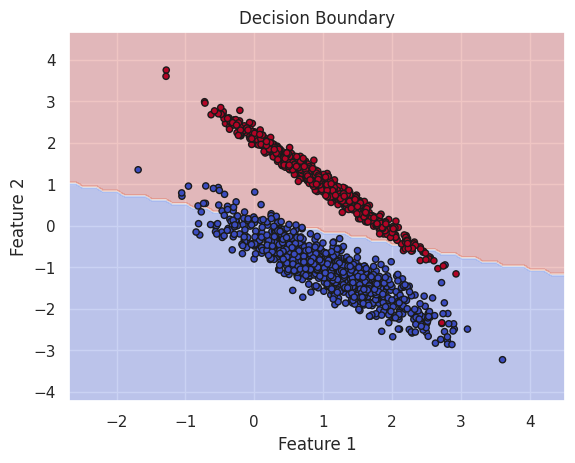

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    plt.plot(model.loss_history, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Iterations')
    plt.legend()
    plt.show()


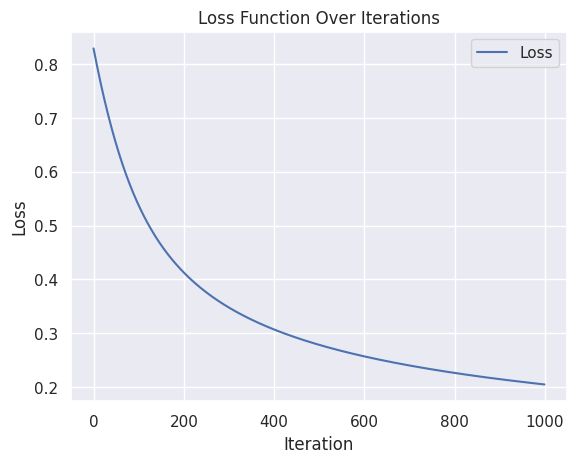

In [ ]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [ ]:
# Параметры для SVC
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100]

# Словарь для хранения результатов
results = []

for kernel in kernels:
    for C in C_values:
        # Обучение модели SVC с заданными параметрами
        svc = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        svc.fit(X, y)

        # Предсказания на обучающих данных
        y_pred = svc.predict(X)
        y_proba = svc.predict_proba(X)[:, 1]  # Вероятности для AUC-ROC

        # Вычисление метрик
        acc = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        auc_roc = roc_auc_score(y, y_proba)
        f1 = f1_score(y, y_pred)

        # Сохранение результатов
        results.append({
            'kernel': kernel,
            'C': C,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'AUC-ROC': auc_roc,
            'F1-Score': f1
        })

# Вывод результатов
results_df = pd.DataFrame(results)
print(results_df)


     kernel      C  Accuracy  Precision    Recall   AUC-ROC  F1-Score
0    linear    0.1  0.995556   0.994451  0.996663  0.996284  0.995556
1    linear    1.0  0.995556   0.994451  0.996663  0.996501  0.995556
2    linear   10.0  0.995556   0.994451  0.996663  0.996531  0.995556
3    linear  100.0  0.995556   0.994451  0.996663  0.996530  0.995556
4      poly    0.1  0.996111   0.995556  0.996663  0.995833  0.996109
5      poly    1.0  0.996111   0.995556  0.996663  0.996740  0.996109
6      poly   10.0  0.996111   0.995556  0.996663  0.996883  0.996109
7      poly  100.0  0.996111   0.995556  0.996663  0.996815  0.996109
8       rbf    0.1  0.996111   0.995556  0.996663  0.997351  0.996109
9       rbf    1.0  0.996111   0.995556  0.996663  0.998004  0.996109
10      rbf   10.0  0.996111   0.995556  0.996663  0.998357  0.996109
11      rbf  100.0  0.996111   0.995556  0.996663  0.998201  0.996109
12  sigmoid    0.1  0.962778   0.982599  0.942158  0.986199  0.961953
13  sigmoid    1.0  

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from collections import Counter

In [ ]:
import numpy as np
from collections import Counter

class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        """
        n_neighbors: int, количество ближайших соседей для классификации
        metric: str, метрика расстояния ('euclidean', 'manhattan' или 'chebyshev')
        """
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Сохранение обучающих данных.
        """
        self.X_train = X
        self.y_train = y

    def _compute_distance(self, X):
        """
        Вычисление расстояния между каждым объектом в X и объектами обучающего набора.
        """
        if self.metric == 'euclidean':
            distances = np.sqrt(((self.X_train - X[:, np.newaxis]) ** 2).sum(axis=2))
        elif self.metric == 'manhattan':
            distances = np.abs(self.X_train - X[:, np.newaxis]).sum(axis=2)
        else:
            raise ValueError("Неизвестная метрика. Используйте 'euclidean', 'manhattan'")
        return distances

    def predict(self, X):
        """
        Предсказание метки класса для каждого объекта в X.
        """
        distances = self._compute_distance(X)
        neighbors_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        neighbors_labels = self.y_train[neighbors_indices]

        # Предсказание метки класса как наиболее частой среди ближайших соседей
        predictions = np.array([Counter(row).most_common(1)[0][0] for row in neighbors_labels])
        return predictions

    def predict_proba(self, X):
        """
        Вычисление вероятностей для каждого класса на основе ближайших соседей.
        """
        distances = self._compute_distance(X)
        neighbors_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        neighbors_labels = self.y_train[neighbors_indices]

        # Рассчитываем вероятности для каждого класса
        probas = np.array([
            [np.sum(row == cls) / self.n_neighbors for cls in np.unique(self.y_train)]
            for row in neighbors_labels
        ])
        return probas


In [ ]:
knn = KNNClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X, y)

# Предсказания и вероятности
y_pred = knn.predict(X)
y_proba = knn.predict_proba(X)[:, 1]  # Вероятности для класса 1

# Вычисление метрик
acc = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
auc_roc = roc_auc_score(y, y_proba)
f1 = f1_score(y, y_pred)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc_roc}")
print(f"F1-Score: {f1}")

Accuracy: 0.9955555555555555
Precision: 0.9944506104328524
Recall: 0.996662958843159
AUC-ROC: 0.9999191357026367
F1-Score: 0.9955555555555555


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
df=pd.read_csv('train.csv')
df.head()

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.columns

Index(['Id', 'Category', 'Pixel000', 'Pixel001', 'Pixel002', 'Pixel003',
       'Pixel004', 'Pixel005', 'Pixel006', 'Pixel007',
       ...
       'Pixel774', 'Pixel775', 'Pixel776', 'Pixel777', 'Pixel778', 'Pixel779',
       'Pixel780', 'Pixel781', 'Pixel782', 'Pixel783'],
      dtype='object', length=786)

In [ ]:
df.Category.value_counts()

,count
Category,
2,6000
9,6000
6,6000
0,6000
3,6000
4,6000
5,6000
8,6000
7,6000


In [ ]:
train=df[:50000]
test=df[50000:]
train.shape, test.shape

((50000, 786), (10000, 786))

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

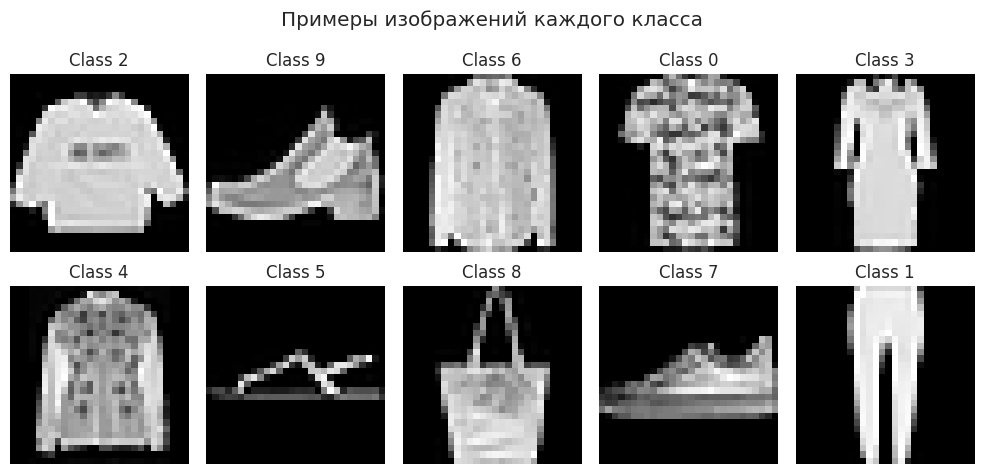

In [ ]:
labels = train['Category']
data = train.drop(columns=['Category','Id'])

# Визуализация одного представителя каждого класса
unique_labels = labels.unique()
plt.figure(figsize=(10, 5))

for i, label in enumerate(unique_labels):
    # Получаем первое изображение данного класса
    image = data[labels == label].iloc[0].values.reshape(28, 28)  # Изменяем форму на 28x28

    # Отображаем
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Class {label}')
    plt.axis('off')

plt.suptitle("Примеры изображений каждого класса")
plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
labels_train = train['Category']
data_train = train.drop(columns=['Category','Id'])

labels_test = test['Category']
data_test = test.drop(columns=['Category','Id'])

standard_scaler = StandardScaler()
data_train_standard_scaled = standard_scaler.fit_transform(data_train)
data_test_standard_scaled = standard_scaler.transform(data_test)

# Нормализация с помощью MinMaxScaler
minmax_scaler = MinMaxScaler()
data_train_minmax_scaled = minmax_scaler.fit_transform(data_train)
data_test_minmax_scaled = minmax_scaler.transform(data_test)

# Преобразуем обратно в DataFrame для удобства
data_train_standard_scaled_df = pd.DataFrame(data_train_standard_scaled, columns=data_train.columns)
data_test_standard_scaled_df = pd.DataFrame(data_test_standard_scaled, columns=data_test.columns)

data_train_minmax_scaled_df = pd.DataFrame(data_train_minmax_scaled, columns=data_train.columns)
data_test_minmax_scaled_df = pd.DataFrame(data_test_minmax_scaled, columns=data_test.columns)

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

**Гиперпараметры для подбора**

*Logit (log reg)*:

- beta: Параметр регуляризации L2. Я подберу значения 0.0, 0.01, 0.1 и 1.0, чтобы исследовать влияние регуляризации на переобучение.
- gamma: Параметр регуляризации L1. Подберу те же значения, чтобы увидеть, как L1-регуляризация влияет на производительность.
- lr: cкорость обучения. Попробую 1e-3, 1e-2 и 1e-1 для оценки влияния скорости обучения на сходимость.
- max_iter: Максимальное количество итераций. Подберу 100, 500 и 1000 для анализа необходимого времени для сходимости.

*KNNClassifier*:

- n_neighbors: Количество соседей. Подберу значения 3, 5, 7 и 10, так как они представляют разные уровни влияния на предсказания.
- metric: Метрика расстояния. Попробую 'euclidean', 'manhattan' и 'chebyshev', чтобы увидеть, какая метрика лучше работает с данными.

Первый вариант (from scratch модели)

In [ ]:
from sklearn.model_selection import  GridSearchCV

Поскольку KNN оказался требовательным к ресурсам, реализован batchgenerator

In [ ]:
class BatchGenerator:
    def __init__(self, data, labels, batch_size):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.n_batches = len(data) // batch_size + (1 if len(data) % batch_size > 0 else 0)

    def __iter__(self):
        for i in range(self.n_batches):
            start_index = i * self.batch_size
            end_index = min((i + 1) * self.batch_size, len(self.data))
            yield self.data[start_index:end_index], self.labels[start_index:end_index]


Нужно немного переписать класс KNN чтобы он работал с gridsearch

In [ ]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _compute_distance(self, X):
        if self.metric == 'euclidean':
            distances = np.sqrt(((self.X_train - X[:, np.newaxis]) ** 2).sum(axis=2))
        elif self.metric == 'manhattan':
            distances = np.abs(self.X_train - X[:, np.newaxis]).sum(axis=2)
        else:
            raise ValueError("Неизвестная метрика. Используйте 'euclidean', 'manhattan'")
        return distances

    def predict(self, X):
        distances = self._compute_distance(X)
        neighbors_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        # Извлекаем метки соседей
        neighbors_labels = self.y_train.values[neighbors_indices]

        # Предсказание метки класса как наиболее частой среди ближайших соседей
        predictions = np.array([Counter(row).most_common(1)[0][0] for row in neighbors_labels])
        return predictions

    def predict_proba(self, X):
        distances = self._compute_distance(X)
        neighbors_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        # Извлекаем метки соседей
        neighbors_labels = self.y_train.values[neighbors_indices]

        # Рассчитываем вероятности для каждого класса
        probas = np.array([
            [np.sum(row == cls) / self.n_neighbors for cls in np.unique(self.y_train)]
            for row in neighbors_labels
        ])
        return probas


    def get_params(self, deep=True):
        return {
            'n_neighbors': self.n_neighbors,
            'metric': self.metric
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [ ]:
labels_train = train['Category']
data_train = train.drop(columns=['Category','Id'])
labels_test = test['Category']
data_test = test.drop(columns=['Category','Id'])

# Нормализация
scaler = StandardScaler()

results = {}

# Нормализация данных
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)


In [ ]:
# Подбор гиперпараметров для Logit
logit_param_grid = {
    'beta': [0.1, 1.0],
    'gamma': [0.1, 1.0],
    'lr': [1e-2, 1e-1],
    'max_iter': [100]
}

# Инициализация GridSearchCV
logit_grid_search = GridSearchCV(Logit(), logit_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

print(f"Подбор гиперпараметров для Logit с StandardScaler...")
logit_grid_search.fit(data_train_scaled, labels_train)

# Тестирование на тестовых данных
logit_best_model = logit_grid_search.best_estimator_
logit_predictions = logit_best_model.predict(data_test_scaled)
logit_accuracy = accuracy_score(labels_test, logit_predictions)

results[f'Logit_StandardScaler'] = {
    'best_params': logit_grid_search.best_params_,
    'accuracy': logit_accuracy
}
# Вывод результатов
print(f"Результаты подбора гиперпараметров для Logit с StandardScaler:")
print(f"Лучшие параметры: {results['Logit_StandardScaler']['best_params']}")
print(f"Точность на тестовых данных: {results['Logit_StandardScaler']['accuracy']:.4f}")

Подбор гиперпараметров для Logit с StandardScaler...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Результаты подбора гиперпараметров для Logit с StandardScaler:
Лучшие параметры: {'beta': 0.1, 'gamma': 0.1, 'lr': 0.01, 'max_iter': 100}
Точность на тестовых данных: 0.1001


In [ ]:
# Подбор гиперпараметров для KNNClassifier

knn_param_grid = {
    'n_neighbors': [3, 4, 5],
    'metric': ['euclidean', 'manhattan']
}

# Создание генератора батчей
batch_size = 100  # Установите размер батча
batch_generator = BatchGenerator(data_train_scaled, labels_train, batch_size)

results = {}

# Инициализация GridSearchCV без многопоточности
knn_grid_search = GridSearchCV(KNNClassifier(), knn_param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=5)

for batch_data, batch_labels in batch_generator:
    print(f"Обработка батча с {len(batch_data)} образцами...")
    knn_grid_search.fit(batch_data, batch_labels)

# Тестирование на тестовых данных
knn_best_model = knn_grid_search.best_estimator_
knn_predictions = knn_best_model.predict(data_test_scaled)
knn_accuracy = accuracy_score(labels_test, knn_predictions)

results['KNN_StandardScaler'] = {
    'best_params': knn_grid_search.best_params_,
    'accuracy': knn_accuracy
}

# Вывод результатов
print(f"Результаты подбора гиперпараметров для KNN с StandardScaler:")
print(f"Лучшие параметры: {results['KNN_StandardScaler']['best_params']}")
print(f"Точность на тестовых данных: {results['KNN_StandardScaler']['accuracy']:.4f}")


Выходные данные были обрезаны до нескольких последних строк (5000).
[CV 1/5] END ...metric=manhattan, n_neighbors=5;, score=0.700 total time=   0.0s
[CV 2/5] END ...metric=manhattan, n_neighbors=5;, score=0.550 total time=   0.0s
[CV 3/5] END ...metric=manhattan, n_neighbors=5;, score=0.600 total time=   0.0s
[CV 4/5] END ...metric=manhattan, n_neighbors=5;, score=0.300 total time=   0.0s
[CV 5/5] END ...metric=manhattan, n_neighbors=5;, score=0.400 total time=   0.0s
Обработка батча с 100 образцами...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...metric=euclidean, n_neighbors=3;, score=0.400 total time=   0.0s
[CV 2/5] END ...metric=euclidean, n_neighbors=3;, score=0.700 total time=   0.0s
[CV 3/5] END ...metric=euclidean, n_neighbors=3;, score=0.750 total time=   0.0s
[CV 4/5] END ...metric=euclidean, n_neighbors=3;, score=0.500 total time=   0.0s
[CV 5/5] END ...metric=euclidean, n_neighbors=3;, score=0.400 total time=   0.0s
[CV 1/5] END ...metric=eucl

In [ ]:
# Сравнение моделей
if knn_accuracy > logit_accuracy:
    print("KNeighborsClassifier показывает лучшее качество.")
else:
    print("LogisticRegression показывает лучшее качество.")

KNeighborsClassifier показывает лучшее качество.


Поскольку KNN показал более лучшее качество, то можно судить о том, что данные линейно не разделимы, а подход через поиск ближайшего соседа по расстоянию более оправдан,также возможно, что для Log Reg сработало проклятие размерности, поэтому KNN справился лучше

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

np.random.seed(42)

# Генерация выборки
n_samples = 10000
X = np.ones((n_samples, 2))  # Признаки (двумерный массив), все одинаковые
y = np.array([0] * 5000 + [1] * 5000)  # 5000 отрицательных и 5000 положительных классов

# Создаем DataFrame для удобства
data = pd.DataFrame(X, columns=['Feature1', 'Feature2'])
data['Category'] = y

# Разделение на обучающий и тестовый наборы
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Обучение логистической регрессии
model = LogisticRegression(solver='liblinear')
model.fit(train_data[['Feature1', 'Feature2']], train_data['Category'])

# Прогнозирование на тестовом наборе
predictions = model.predict(test_data[['Feature1', 'Feature2']])

# Оценка точности
accuracy = accuracy_score(test_data['Category'], predictions)
accuracy


0.49

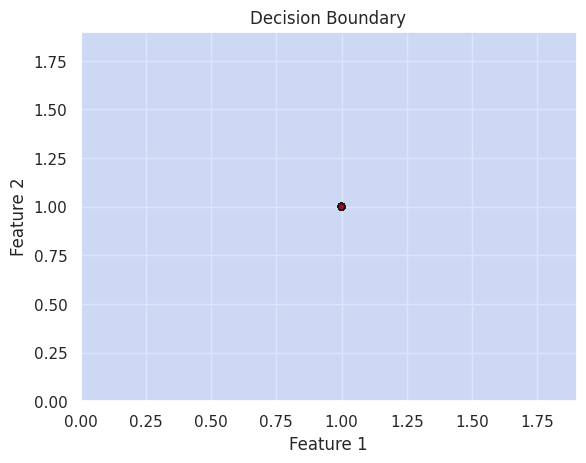

In [ ]:
plot_decision_boundary(model, X, y)


В результате обучения логистической регрессии на сгенерированном датасете с 10,000 объектами, где все признаки одинаковы, модель продемонстрировала точность  49% (В теории 50%). Это происходит из-за следующего:

- Однородность признаков: Все объекты имеют одинаковые значения для обоих признаков (равны 1). Это приводит к тому, что логистическая регрессия не может различить между классами, так как нет информации, которая могла бы помочь в разделении.

- Дисбаланс классов: В выборке 5000 объектов положительного класса и 5000 — отрицательного. Когда признаки одинаковы, модель не может делать осмысленные предсказания и в большинстве случаев будет угадать случайным образом, что приводит к точности близкой к 50%, что соответствует случайному выбору.

Таким образом, если признаки одинаковы для всех объектов, то логистическая регрессия не сможет обучиться эффективно, и результаты окажутся близкими к случайным.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

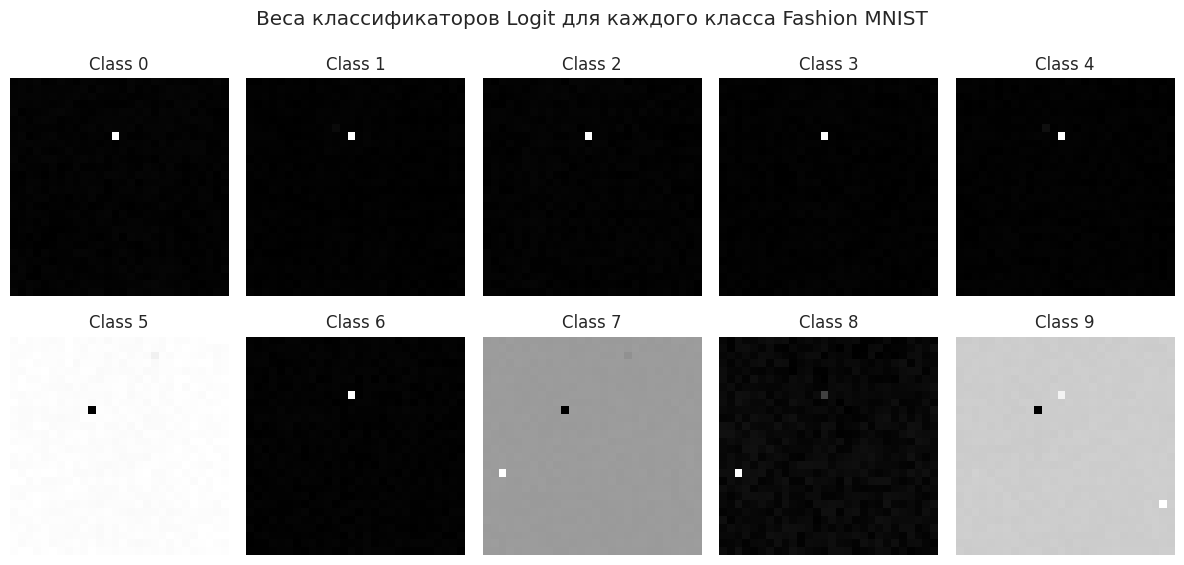

In [ ]:
# Список для хранения весов каждого из классификаторов
weights_list = []

# Обучение One-Vs-All моделей для каждого класса
unique_labels = np.unique(labels_train)

for label in unique_labels:

    logit_model = Logit(beta=0.1, gamma=0.1, lr=1e-2, max_iter=1000)
    # бинарные метки: 1 для текущего класса, 0 для остальных
    y_binary = (labels_train == label).astype(int)
    logit_model.fit(data_train_scaled, y_binary)
    weights_list.append(logit_model.w)

# Визуализация весов каждого из классификаторов как изображений
plt.figure(figsize=(12, 6))
for i, weight in enumerate(weights_list):
    weight_image = weight.reshape(28, 28)
    plt.subplot(2, 5, i + 1)
    plt.imshow(weight_image, cmap='gray')
    plt.title(f'Class {unique_labels[i]}')
    plt.axis('off')

plt.suptitle("Веса классификаторов Logit для каждого класса Fashion MNIST")
plt.tight_layout()
plt.show()

На основе визуализации можно сделать следующие выводы:
- Отсутствие явных паттернов: Картинки весов для всех классов выглядят довольно случайными и не показывают ярко выраженных контуров или форм. Это может означать, что модель не смогла выделить характерные графические паттерны для каждого класса.

- Недостаток обучения или неправильные параметры: Такой результат может указывать на то, что модель либо недостаточно обучена, либо стоит провести дополнительные эксперименты с гиперпараметрами

- Слабая разделимость классов: Возможно, логистическая регрессия в конфигурации One-Versus-All не подходит для этой задачи

- Слабая модель: для классификации картинок стоит попробовать более сложные модели

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb_classifier = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbosity=2, n_jobs=-1)

xgb_classifier.fit(data_train_scaled , labels_train, verbose=True )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = xgb_classifier.predict(data_test_scaled )
accuracy = accuracy_score(labels_test, y_pred)

print("Accuracy on test data:", accuracy)
print(classification_report(labels_test, y_pred))

Accuracy on test data: 0.8851
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1001
           1       0.99      0.97      0.98       996
           2       0.80      0.81      0.81      1004
           3       0.89      0.91      0.90      1017
           4       0.78      0.81      0.80       997
           5       0.97      0.96      0.97       971
           6       0.73      0.64      0.68       986
           7       0.95      0.95      0.95      1003
           8       0.97      0.96      0.97      1017
           9       0.95      0.95      0.95      1008

    accuracy                           0.89     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.89      0.88     10000



Модель XGboost, как и другие реализации градиентного бустинга на деревьях, может переобучаться. Однако в данной задаче цель была побить accuracy, что и было сделано